In [56]:
!pip install llamaapi -q

In [75]:
from llamaapi import LlamaAPI
import json
llama = LlamaAPI('LL-.........')

# **`MIXTURE OF AGENTS`**

PAPER LINK : https://arxiv.org/abs/2406.04692

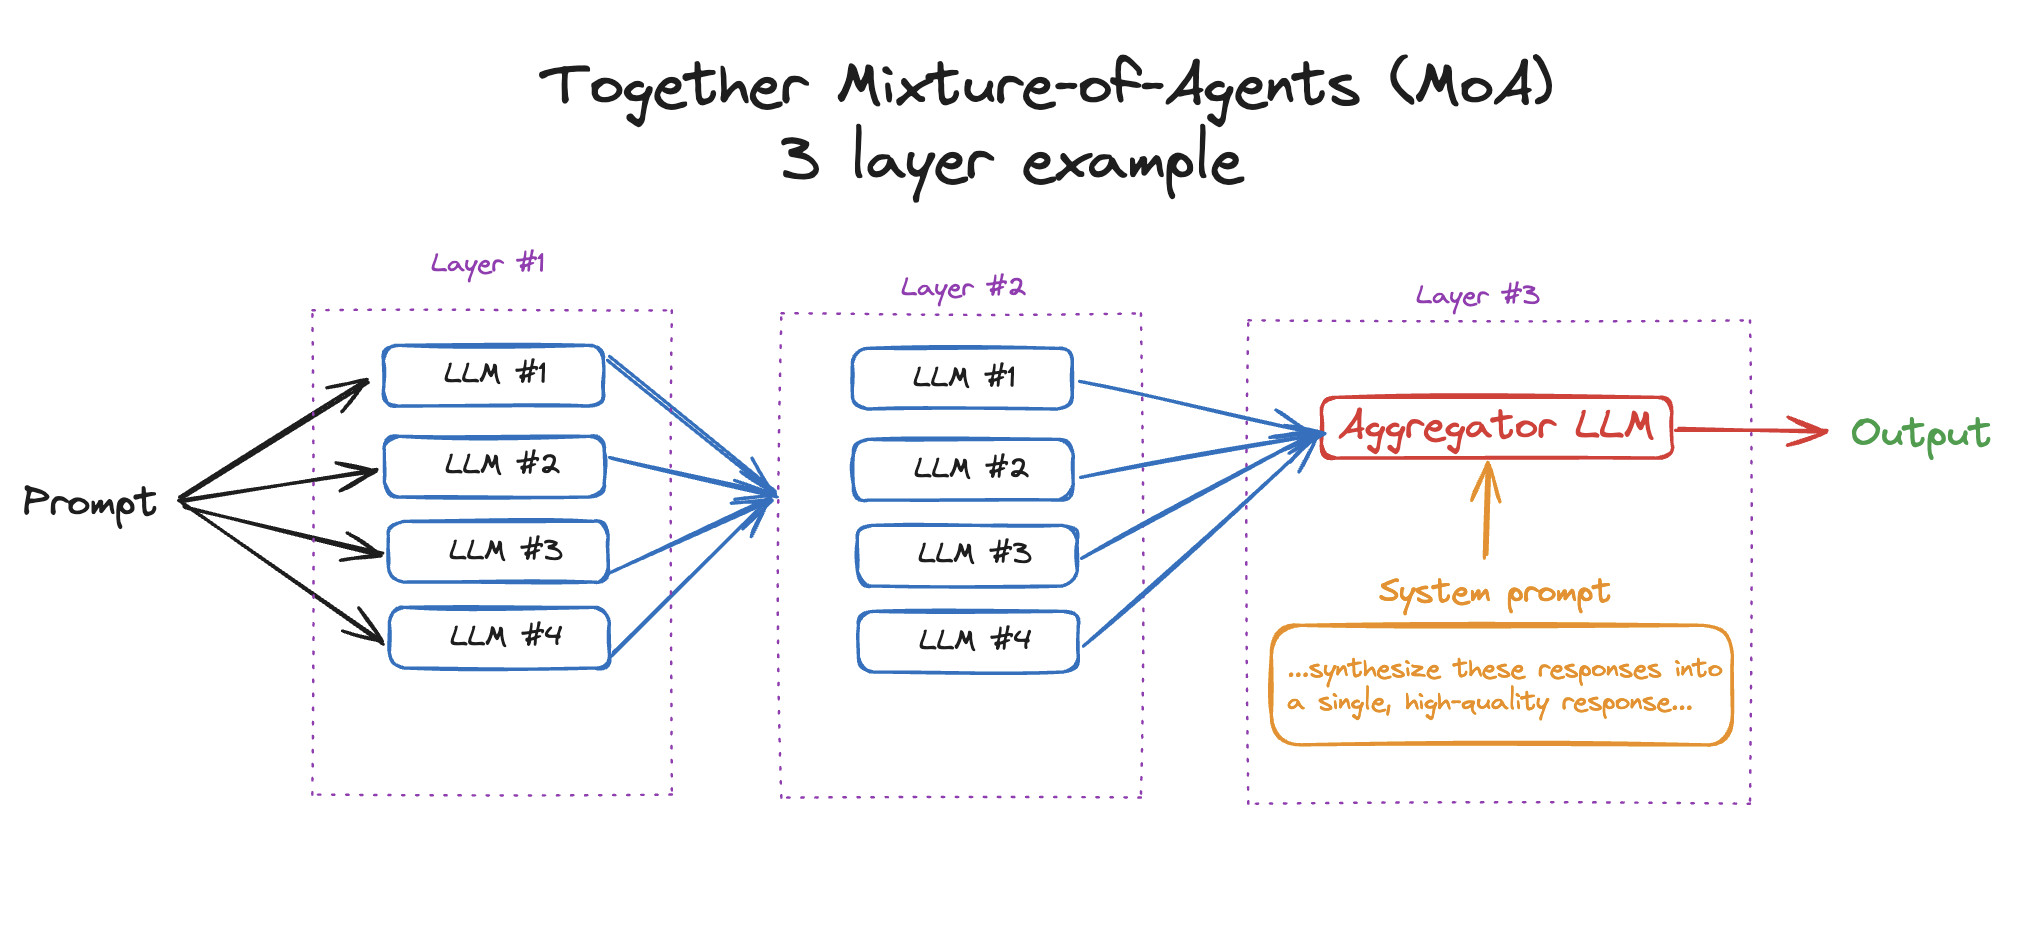

This code loosely implements the "Mixture of Agents" concept by creating multiple instances of a Llama model to independently generate responses (`proposer` models), then aggregates these responses into a single, coherent answer using another Llama model (`aggregator`). Each layer takes the initial user query and previous layer's output to progressively refine the response. The code simulates deeper reasoning with increasing layer numbers by re-evaluating and aggregating inputs at each stage.

In [86]:
class Layer:
    def __init__(self, user_input, prev_input=None, layer_no=0):
        self.user_input = user_input
        self.prev_input = prev_input if prev_input is not None else user_input
        self.layer_no = layer_no

    def model_initializations(self):
        llama_model1 = self.proposer(self.user_input, self.layer_no, "llama3-70b")
        llama_model2 = self.proposer(self.user_input, self.layer_no, "llama3-70b")
        llama_model3 = self.proposer(self.user_input, self.layer_no, "llama3-70b")

        aggregator = self.aggregator_api(self.user_input, self.prev_input, llama_model1, llama_model2, llama_model3, self.layer_no)

        return self.user_input, self.prev_input, aggregator

    def proposer(self, user_input, layer_no, model_name):
        api_request_json = {
            "model": model_name,
            "messages": [
                {
                    "role": "system",
                    "content": (
                        f"You are a llama assistant where you take the user input and check the layer_no. "
                        f"If it is higher, then reason the input more deeply. For this stage of reasoning, the layer_no is {layer_no}. "
                        "Only provide the answer to the point, no greetings and starting quotes, just directly start with the answer."
                    )
                },
                {"role": "user", "content": user_input},
            ]
        }
        response = llama.run(api_request_json)
        answer = dict(response.json())  # Assuming response.json() returns a dictionary

        return answer['choices'][0]['message']['content']

    def aggregator_api(self, user_input, prev_input, llama_model1, llama_model2, llama_model3, layer_no):
        api_request_json = {
            "model": "llama2-70b-chat",
            "messages": [
                {
                    "role": "system",
                    "content": (
                        f"Only give the answer to the point. "
                        f"You are an aggregator where you take the three outputs from proposer models and check the layer_no and aggregate them into a single answer. "
                        f"If it is higher, then reason the inputs more deeply. Take the three inputs separated by commas at the end and score them according to the 'Question' input from the user. "
                        f"Aggregate them into a single answer, giving the higher score's outputs more impact in the aggregation. "
                        f"Check for the correct answer from your reasoning and do the tasks."
                    )
                },
                {
                    "role": "user",
                    "content": (
                        f"""
                        You have been provided with a set of responses from various open-source models to the latest user query. Your
                        task is to synthesize these responses into a single, high-quality response. It is crucial to critically evaluate the
                        information provided in these responses, recognizing that some of it may be biased or incorrect. Your response
                        should not simply replicate the given answers but should offer a refined, accurate, and comprehensive reply
                        to the instruction. Ensure your response is well-structured, coherent, and adheres to the highest standards of
                        accuracy and reliability.
                        """
                        f"This is the Question: {user_input}."
                        f"Outputs from the proposer models:\n"
                        f"1: {llama_model1}\n"
                        f"2: {llama_model2}\n"
                        f"3: {llama_model3}\n"
                        f"Only provide the answer to the point, no greetings and starting quotes, just directly start with the answer. "
                        f"Only give the aggregated answer, do not give unnecessary things like showing each output for each model and so on."
                        f"Only Give the final answer as a single sentence"
                    )
                }
            ]
        }
        response = llama.run(api_request_json)
        answer = response.json()
        return answer['choices'][0]['message']['content']

In [87]:
user_input = """Albert is wondering how much pizza he can eat in one day.
          He buys 2 large pizzas and 2 small pizzas.
          A large pizza has 16 slices and a small pizza has 8 slices.
          If he eats it all, how many pieces does he eat that day ?"""
prev_input = None
layer_no = 1

In [89]:
layer1 = Layer(user_input, prev_input, layer_no)
user_input, prev_input, aggregator_output = layer1.model_initializations()

layer2 = Layer(user_input, aggregator_output, layer_no + 1)
user_input, prev_input, aggregator_output = layer2.model_initializations()

layer3 = Layer(user_input, aggregator_output, layer_no + 2)
user_input, prev_input, aggregator_output = layer3.model_initializations()


print(aggregator_output)


Sure! Here is the aggregated answer to the question:

Albert eats 48 slices of pizza in a day.
